# Import Library

In [2]:
import mnist

In [3]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# GAN Architecture

## Generator 👨🏻‍🎨

In [4]:
def GenBlock(in_dim:int,out_dim:int):
   
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.BatchNorm(out_dim),
        nn.ReLU()
    )

In [5]:
class Generator(nn.Module):

    def __init__(self, z_dim:int = 10, im_dim:int = 784, hidden_dim: int =128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            GenBlock(z_dim, hidden_dim),
            GenBlock(hidden_dim, hidden_dim * 2),
            GenBlock(hidden_dim * 2, hidden_dim * 4),
            GenBlock(hidden_dim * 4, hidden_dim * 8),


            nn.Linear(hidden_dim * 8,im_dim),
            nn.Sigmoid()
        )
        
    def __call__(self, noise):

        return self.gen(noise)

In [7]:
gen = Generator(100)
gen

Generator(
  (gen): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=100, output_dims=128, bias=True)
      (layers.1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=128, output_dims=256, bias=True)
      (layers.1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=512, bias=True)
      (layers.1): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.3): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=1024, bias=True)
      (layers.1): BatchNorm(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.4): Linear(input_dims=1024, output_dims=784, bias=True

In [8]:
def get_noise(n_samples, z_dim):
    return np.random.randn(n_samples,z_dim)

## Discriminator 🕵🏻‍♂️

In [9]:
def DisBlock(in_dim:int,out_dim:int):
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [10]:
class Discriminator(nn.Module):

    def __init__(self,im_dim:int = 784, hidden_dim:int = 128):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            DisBlock(im_dim, hidden_dim * 4),
            DisBlock(hidden_dim * 4, hidden_dim * 2),
            DisBlock(hidden_dim * 2, hidden_dim),

            nn.Linear(hidden_dim,1),
        )
        
    def __call__(self, noise):

        return self.disc(noise)

In [11]:
disc = Discriminator()
disc

Discriminator(
  (disc): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=784, output_dims=512, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=256, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=128, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.3): Linear(input_dims=128, output_dims=1, bias=True)
  )
)

# Model Training 🏋🏻‍♂️

In [12]:
# Set your parameters
criterion = nn.losses.binary_cross_entropy
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

In [13]:
gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr)

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr)

## Losses

In [71]:
def disc_loss(gen, disc, real, num_images, z_dim):
    noise =  mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
        
    fake_disc = disc(fake_images)
    
    fake_labels = mx.zeros((fake_images.shape[0],1))
    fake_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True)
    
    real_disc = disc(real)
    real_labels = mx.ones((real.shape[0],1))

    real_loss = nn.losses.binary_cross_entropy(real_disc,real_labels,with_logits=True)

    disc_loss = (fake_loss + real_loss) / 2

    return disc_loss

In [72]:
def gen_loss(gen, disc, num_images, z_dim):

    noise = mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
    fake_disc = disc(fake_images)

    fake_labels = mx.ones((fake_images.shape[0],1))
    
    gen_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True)

    return gen_loss

In [26]:
train_images, _, test_images, _ = map(
    mx.array, getattr(mnist, 'mnist')()
)

In [59]:
def batch_iterate(batch_size:int, ipt:list):
    perm = mx.array(np.random.permutation(len(ipt)))
    for s in range(0, ipt.size, batch_size):
        ids = perm[s : s + batch_size]
        yield ipt[ids]

### show batch of images

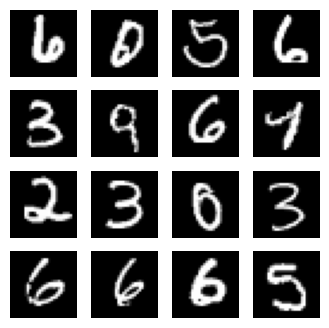

In [60]:
for X in batch_iterate(16, train_images):
    fig,axes = plt.subplots(4, 4, figsize=(4, 4))

    for i, ax in enumerate(axes.flat):
        img = mx.array(X[i]).reshape(28,28)
        ax.imshow(img,cmap='gray')
        ax.axis('off')
    break

In [41]:
z_dim = 64
gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr)

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr)

g_loss = gen_loss(gen, disc, 8, z_dim)
g_loss


array(0.677068, dtype=float32)

In [77]:
batch_size = 8
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

D_loss_grad = nn.value_and_grad(disc, disc_loss)
G_loss_grad = nn.value_and_grad(gen, gen_loss)


for epoch in tqdm(range(5)):
  
    for real in batch_iterate(batch_size, train_images):
    
        # real = real.reshape(-1)
        
        # Flatten the batch of real images from the dataset
        
        # plt.imshow(real[0].reshape(28,28))
        # print(len(real))
        # break
                
        D_loss,D_grads = D_loss_grad(gen, disc, real, batch_size, z_dim)

        # Update optimizer
        disc_opt.update(disc, D_grads)
        
        # Update gradients
        mx.eval(disc.parameters(), disc_opt.state)

        
        G_loss,G_grads = G_loss_grad(gen, disc, batch_size, z_dim)
        
        # Update optimizer
        gen_opt.update(gen, G_grads)
        
        # Update gradients
        mx.eval(gen.parameters(), gen_opt.state)

        print(f"Step {epoch}: Generator loss: {G_loss}, discriminator loss: {D_loss}")

        # # Keep track of the average discriminator loss
        # mean_discriminator_loss += disc_loss.item() / display_step

        # # Keep track of the average generator loss
        # mean_generator_loss += gen_loss.item() / display_step

        # ### Visualization code ###
        # if cur_step % display_step == 0 and cur_step > 0:
        #     print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
        #     fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        #     fake = gen(fake_noise)
        #     show_tensor_images(fake)
        #     show_tensor_images(real)
        #     mean_generator_loss = 0
        #     mean_discriminator_loss = 0
        # cur_step += 1


KeyboardInterrupt: 

In [69]:
z_dim = 64
gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr)

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr)

for real in tqdm(batch_iterate(batch_size, train_images)):
    d_loss = disc_loss(gen, disc, real, batch_size, z_dim)


841it [00:00, 4302.26it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

1272it [00:00, 4216.43it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

2162it [00:00, 3892.48it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

3019it [00:00, 4091.56it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

3844it [00:00, 4029.28it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

4650it [00:01, 3939.91it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

5458it [00:01, 3936.87it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

6227it [00:01, 3545.49it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

7012it [00:01, 3731.90it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

7390it [00:01, 3631.14it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (8, 1) (8, 1)
fake image shape (8, 784)
Fake S

8155it [00:02, 3723.22it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

8894it [00:02, 3526.49it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

9599it [00:02, 3156.01it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

10276it [00:02, 3261.29it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

10949it [00:02, 3314.05it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

11617it [00:03, 3302.76it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

12300it [00:03, 2989.43it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

12965it [00:03, 3146.40it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

13614it [00:03, 3125.70it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

13930it [00:03, 2767.20it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

14528it [00:04, 2874.43it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

15107it [00:04, 2529.70it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

15646it [00:04, 2603.14it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

16166it [00:04, 2521.59it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

16448it [00:04, 2605.58it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

16986it [00:05, 2527.43it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

17536it [00:05, 2377.32it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

18083it [00:05, 2559.46it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

18343it [00:05, 2557.61it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

18862it [00:05, 2306.06it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

19370it [00:06, 2369.58it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

19612it [00:06, 2167.17it/s]

fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake Shapes..... (8, 1) (8, 1)
Real Shapes..... (0, 1) (0, 1)
fake image shape (8, 784)
Fake S

19835it [00:06, 3062.01it/s]


KeyboardInterrupt: 